In [8]:
import os 
from generator import Generator

from keras.models import Sequential 
from keras.layers import Flatten, Dense, Dropout, Cropping2D, Lambda
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras import losses, optimizers, metrics, backend, regularizers 
from keras.constraints import maxnorm
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from keras.layers.normalization import BatchNormalization

def resize(img):
    from keras.backend import tf as ktf
    return ktf.image.resize_images(img, [90, 160])

In [13]:
def build_model(drop_prob = 0.2, learn_rate=0.001, constraint=maxnorm(3), reg = None, verbose = False): 
    backend.clear_session()
    model = Sequential()

    ###--- Convolutional Neural Network --- ### 
    input_shape = (180, 320, 3)

    model.add(Cropping2D(cropping=((60, 0), (0, 0)), input_shape=input_shape))
    # model.add(Lambda(resize, input_shape=input_shape))
    model.add(BatchNormalization(name='r0'))

    ### conv. layers 
    model.add(Convolution2D(filters=24,
                            kernel_size=(5, 5),
                            strides = (2, 2),
                            activation='relu',
                            kernel_regularizer=reg, 
                            input_shape=input_shape, 
                            ))
    '''READ THIS try adding max pool - before min loss was 7.04'''
#     model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization(name='r1'))

    model.add(Convolution2D(filters=36,
                            kernel_size=(5, 5),
                            strides = (2, 2),
                            activation='relu',
                            kernel_regularizer=reg, 
                            ))
    model.add(BatchNormalization(name='r2'))

    model.add(Convolution2D(filters=48,
                            kernel_size=(5, 5),
                            strides = (2, 2),
                            activation='relu',
                            kernel_regularizer=reg, 
                            ))
    model.add(BatchNormalization(name='r3'))

    model.add(Convolution2D(filters=64,
                            kernel_size=(3, 3),
                            strides = (1, 1),
                            activation='relu',
                            kernel_regularizer=reg, 
                            ))
    model.add(BatchNormalization(name='r4'))

    model.add(Convolution2D(filters=64,
                            kernel_size=(1, 1),
                            strides = (1, 1),
                            activation='relu',
                            kernel_regularizer=reg, 
                            ))
    model.add(BatchNormalization(name='r5'))

    ### fully connect layers 
    model.add(Flatten())
    model.add(Dense(1164, activation='relu', kernel_constraint=constraint))
    model.add(Dropout(drop_prob))

    model.add(Dense(100, activation='relu', kernel_constraint=constraint))
    model.add(Dropout(drop_prob))

    model.add(Dense(50, activation='relu', kernel_constraint=constraint))
    model.add(Dropout(drop_prob))

    model.add(Dense(10, activation='relu', kernel_constraint=constraint))
    model.add(Dropout(drop_prob))

    model.add(Dense(1, activation='linear'))

    if verbose: 
        # Summarize the model
        model.summary()
    
    #compile 
    model.compile(loss='mse', optimizer=optimizers.Adam(lr=learn_rate))

    return model 

### Init Data

In [14]:
RUN = 'floyd' # (str) local or floyd 

#select data directories 
if RUN == 'local':  
    train_dir = os.path.join('..', 'data', 'train')
    val_dir = os.path.join('..', 'data', 'validation')
elif RUN == 'floyd':
    train_dir = os.path.join('/input', 'train')
    val_dir = os.path.join('/input', 'validation')
else: 
    print('not a valid directory')
    
#init data generators 
train_gen = Generator(train_dir, batch_size = BATCH_SIZE, normalize = True, SVD = False, flip=False, yuv=True)
val_gen = Generator(val_dir, batch_size = BATCH_SIZE, normalize = True, SVD = False, flip=False, yuv=True)

#optionally train on a subset of the data (check for 0 cost) 
train_gen.img_dir = train_gen.img_dir[:]
val_gen.img_dir = val_gen.img_dir[:]

### Callbacks 

In [15]:
#tensorboard object 
!mkdir logs
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0,
                          write_graph=True, write_images=False)

#save and overwrite models when improved 
filepath="checkpoints/baseline_best.h5"

!mkdir checkpoints
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', save_best_only=True)

early_stop = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=3, verbose=0, mode='auto')

callbacks_list = [checkpoint, tensorboard]

mkdir: cannot create directory ‘logs’: File exists
mkdir: cannot create directory ‘checkpoints’: File exists


### Build Model 

In [16]:
BATCH_SIZE = 256
EPOCHS = 20
LEARN_RATE = 0.0005
DROP_PROB = 0.2

control_model = build_model(drop_prob = DROP_PROB, learn_rate = LEARN_RATE, verbose=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping2d_1 (Cropping2D)    (None, 120, 320, 3)       0         
_________________________________________________________________
r0 (BatchNormalization)      (None, 120, 320, 3)       12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 58, 158, 24)       1824      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 29, 79, 24)        0         
_________________________________________________________________
r1 (BatchNormalization)      (None, 29, 79, 24)        96        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 38, 36)        21636     
_________________________________________________________________
r2 (BatchNormalization)      (None, 13, 38, 36)        144       
__________

### Fit Model

In [17]:
#fit 
hist = control_model.fit_generator(generator = train_gen,
                           steps_per_epoch = len(train_gen.img_dir)//train_gen.batch_size,
                           validation_data = val_gen,
                           validation_steps = len(val_gen.img_dir)//val_gen.batch_size, 
                           epochs = EPOCHS,
                           callbacks = callbacks_list,
                           verbose = 1)

#save final model
model.save('baseline.h5')

Epoch 1/20
 4/73 [>.............................] - ETA: 100s - loss: 25.8887

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.5/site-packages/keras/engine/training.py", line 1840, in fit_generator
    class_weight=class_weight)
  File "/usr/local/lib/python3.5/site-packages/keras/engine/training.py", line 1565, in train_on_batch
    outputs = self.train_function(ins)
  File "/usr/local/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py", line 2268, in __call__
    **self.session_kwargs)
  File "/usr/local/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 778, in run
    run_metadata_ptr)
  File "/usr/local/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 954, in _run
    np_val = np.asarray(subfeed_val, dtype=subfeed_dtype)
  File "/usr/local/lib/python3.5/site-packages/numpy/core/numeric.py", line 531, in asarray
    return array(a, dtype, copy=False, order=order)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  F

TypeError: Can't convert 'list' object to str implicitly

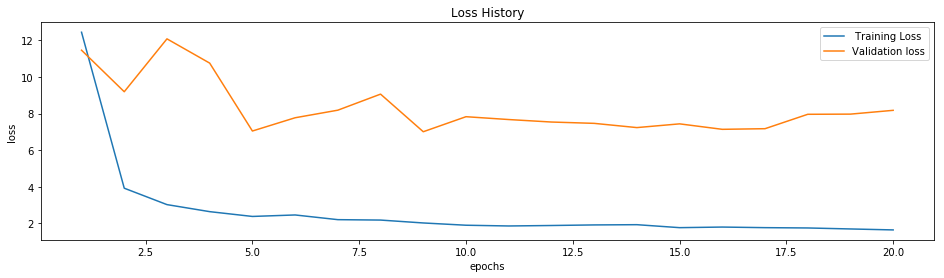

In [6]:
import matplotlib.pyplot as plt
import numpy as np

loss = hist.history['loss']
val_loss = hist.history['val_loss']
x = list(np.linspace(1, len(loss), len(loss)))

plt.figure(figsize=(16, 4))

plt.plot(x, loss, label=' Training Loss') 
plt.plot(x, val_loss, label='Validation loss')
plt.title('Loss History'); plt.xlabel('epochs'); plt.ylabel('loss'); 
plt.legend()
plt.show()

In [7]:
# from skimage.io import imread
# import glob 
# import numpy as np

# def rgb2gray(rgb):
#     '''cvt image from RGB to grayscale'''
#     return np.dot(rgb[:, :, :3], [0.299, 0.587, 0.114]).reshape(1,180, 320, 1)

# test_dir = glob.glob( os.path.join('/input', 'train', 'images') + '/*')
# # for file in test_dir: 
# #     truth = float(file.split('/')[-1].split('_')[-1].split('.')[0])/10
# # #     print (model.predict(rgb2gray(imread(file)))[0][0], truth)